In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm # color stuff
from scipy.optimize import curve_fit
%matplotlib inline

# def pltDefaultPar():
#     #reset default matplotlib parameters for this notebook
#     plt.rcParams.update({'font.size': 20})
#     plt.rcParams['lines.linewidth'] = 1
#     plt.rcParams['lines.markersize'] = 6
    
def pltPrintPar():
    plt.rcParams.update({'font.size': 11})
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['lines.markersize'] = 6

rootTP="/home/johann/Remote/imac"
rootMAC="/Users/jh"
root=rootMAC

# Try different particle size. According to Jason, Alexa488 has a diameter of $1.48$ nanometers.
According to source Johansson1991 water has a diameter of 0.38 and dextran a diameter of 0.389. Hence we get
$$a/p = (.38+.389)/1.48 = 0.52$$

If we want to conserve our approximate mesh size $b=23$nm, with $(p+a) = 2.25 nm$, we need to set
$$p/b = 2.25 / 23= 0.098$$

## NOTE:
I should use $(a+p) = 2.25$ to calculate physical value of b. This way, I can use a/p = 0.33 data in 
/Users/jh/Documents/Remote_PC/sheldon_scratch/HI/sim/Release/sim_data/noreset/fitRPinv/test/CG/ntry1/nrods1/steric/dt0.001/t200/a0.33
and
/Users/jh/Documents/Remote_PC/sheldon_scratch/HI/sim/Release/sim_data/noreset/fitRPinv/test/CG/ntry1/nrods1/steric/dt0.0005/t200/a0.33


## After Evalulation:
I find that I can use a slightly smaller relative particle diameter $(a+p)/b = 0.94$, where I set $a = 0.33b$ and $p = 0.61b$. This leads to a mesh size of $b= 23.9$nm. **BUT THE D/Do IS STILL TOO LARGE**

So, now I try $a = 0.31b$ and $p = 0.57b$. This leads to a mesh size of $b= 25.45$nm.

#### In the HI paper 
I will just mention the physical units, i.e. I will say that $p=1.48$nm and $a=.38+.39 = 0.77$ nm and the mesh size $b=23.9$nm, i.e. slightly larger than in the EPJE and bpj papers.

In [2]:
def Cion(k_rel,b_ex):
    return 0.0924*10**3/((k_rel*b_ex)**2)

def krelFromCion(Cion,b_ex):
    return np.sqrt(0.0924*10**3/(Cion*b_ex**2))

# Cion data with HI

In [3]:
CionFile = root + "/Documents/reports-talk-etc/reports/paper/jason/jason_data-DDo2-w-error.txt"
JasonCionAtt = []
JasonCionRep = []
with open(CionFile, 'r') as f:
    for i, line in enumerate(f):
        if i>0:
            lines = line.split()
            JasonCionAtt.append([lines[0]]+lines[3:])
            if str(lines[1]) != 'x':
                JasonCionRep.append(lines[0:4])
JasonCionAtt = (np.asarray(JasonCionAtt)).astype(float)
JasonCionRep = (np.asarray(JasonCionRep)).astype(float)

In [4]:
a_ex_Cion = 0.38+0.39 #nanometer
aop=0.54

In [5]:
def getCionData(a_rel,uArr,dt,a_ex):
    uArr = [str(u) for u in uArr]
    p=a_rel/aop
    pstr='%s' % float('%g' % p)
    b_ex = a_ex / (a_rel/10.)
    datadir= root + "/Documents/workspace-cpp/SPS/Release/sim_data/noreset/fitRPinv/steric/dt"+dt+"/t200/a"+str(a)+"/d0/b10/p"+pstr
    dataArr=[]
    for u  in uArr:
        folder = datadir
        data = []
        for kdir in os.listdir(folder): 
            k=float(kdir[1:])/10
            file=os.path.join(folder, kdir,'u'+str(u)+'/InstantValues/linear_fit_parametersMSD.txt')
            if os.path.isfile(file):
                with open(file, 'r') as fitf:
                    m = (fitf.readline().split('m')[1]).split()[0]
                data.append([float(k),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
        dataArr.append(np.array(sorted(data)))
    return dataArr, b_ex


In [51]:
def plotCionData(data,b_ex,uArr=[None],toFile=False,filename='tmp'):
    if uArr == [None]:
        uArr = len(data)*[None]
    pltPrintPar()
    plt.figure(facecolor='white',figsize=(6,4))
    plt.errorbar(JasonCionAtt[:,0]+20,JasonCionAtt[:,1],fmt='^',yerr=JasonCionAtt[:,2],label="Dextran(+)")
    plt.errorbar(JasonCionRep[:,0]+16,JasonCionRep[:,1],fmt='^',yerr=JasonCionRep[:,2],label="Dextran(-)")
    for i,dat in enumerate(data):
        ti = str(uArr[i])
        k_rel = dat[:,0]
        dd0 = dat[:,1]/6.
        cpoly = Cion(k_rel,b_ex)
        plt.plot(cpoly,dd0,'o-',label="U_0 = "+ti)
    plt.xlabel(r'$C_{Ion}$ / mM')
    plt.ylabel(r'$D/D_0$')
    plt.xlim([0,225])
    plt.ylim([0,1.15])
    plt.legend(loc=4)
    if toFile:
        plt.rcdefaults()
        plt.savefig('figures/'+filename+'.png', bbox_inches='tight')
    else:
        plt.show()

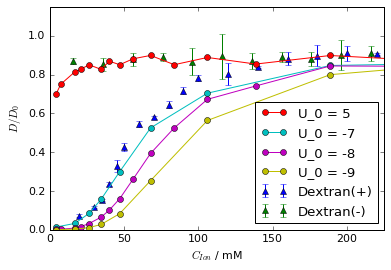

In [42]:
a=0.33
us=['5','-7','-8','-9']
dt='0.0005'
adata, bex = getCionData(a,us,dt,a_ex_Cion)
plotCionData(adata,bex,us,False,'test')

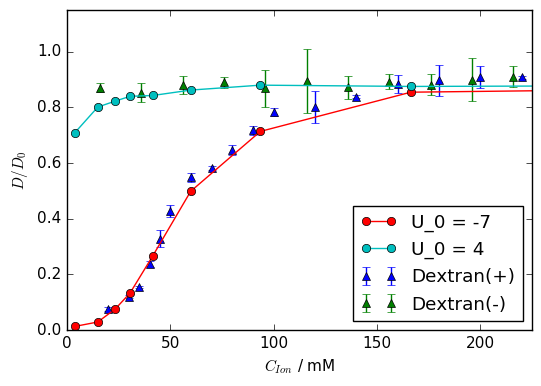

In [66]:
#TODO ! Check AlexaU4CIon Data on yoshi (dt0.001  and no steric)
a=0.31
us=['-7','4']
dt='0.001'
adata, bex = getCionData(a,us,dt,a_ex_Cion)
plotCionData(adata,bex,us,False,'D_over_Cion_HI_aop054_u4_-7_a031')

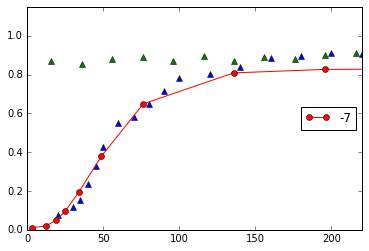

In [76]:
a=0.28
us028=['-7']
dt='0.001'
a028data,bex = getCionData(a,us028,dt,a_ex_Cion)
plotCionData(a028data,bex,us028)

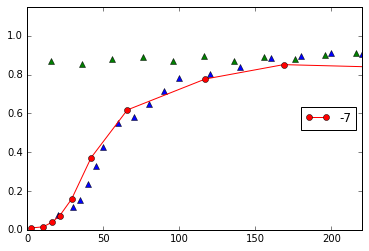

In [77]:
a=0.26
us=['-7']
dt='0.001'
adata,bex = getCionData(a,us,dt,a_ex_Cion)
plotCionData(adata,bex,us)

32.083333333333336


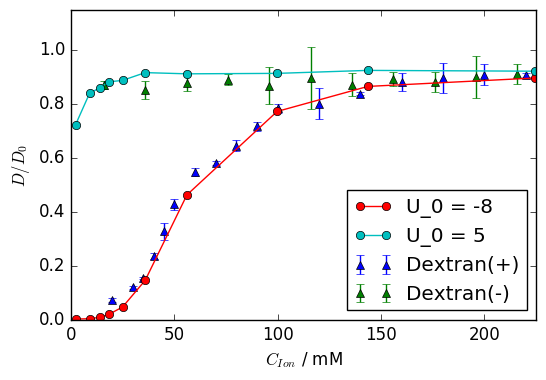

In [56]:
##########
## TODO ##
##########
# Evaluate on sheldon a024aop054Extra data, i.e. this data but with u5 and -8
a=0.24
us=['-8','5']
dt='0.001'
adata,bex = getCionData(a,us,dt,a_ex_Cion)
plotCionData(adata,bex,us,False,'D_over_Cion_HI_aop054_u5_-8_a024')
print(bex)

______
______
______

# Compare bpj fig. 4 data to simulations
Do the same stuff, that I did in EPJE fig. 10, but for finite $U_0$, i.e. Alexa488 in charged dextran.
### Relate ion concentration to k
The experiments were performed at zero added NaCl.
In our bpj paper, we established, that the ion concentration due to the TRIS buffer, plus the  ionic strength of the mobile ions that enter the solution upon addition of 1 wt % dextran(+) and dextran(-) correspond to an ion concentration of 16 and 20 mM for dextran(-) and dextran(+), respectively.
This ion concetration leads to a certain interaction range for our interaction potential.
We can use eq. 9 in the EPJE paper (or eq. 8 in my thesis) to calculate it and we obtain (for b=23nm):

In [76]:
print(krelFromCion(16,25.5), krelFromCion(20,25.5))

0.0942401163976 0.084290922589


$$k_- = 0.1b \quad \text{and} k_+ = 0.093b$$

In [77]:
# For different bex = 32 nm (case aop = 0.54 and a = 0.24 b)
print(krelFromCion(16,32), krelFromCion(20,32))

0.0750975927544 0.0671693289381


In [48]:
# C_polymer FUNCTIONS

#Experimental parameters Dextran And Alexa
m_a=162*1.66
a_exCpoly=0.4 #KEEP THIS AT 0.4!
p_exCpoly=1.9
def prel_simToCalc(p_rel_sim):
    aop_sim = 0.54
    aop_calc = a_exCpoly/p_exCpoly
    return p_rel_sim*(1+aop_sim)/(1+aop_calc)
# This function needs to be used, if I want to calculate the polymer Concentration from the mesh size b
def CpolyFromb(b_ex,a_ex=a_exCpoly):#!=C2(p_s) in gp_polymerConcentration OR SEE BELOW
    n_mono = (3*b_ex/a_ex - 2 ) / b_ex**3
    return n_mono * m_a

# This functions needs to be used to calculate Cpoly from p - In the case of HI, where I have separate a and p
def CpolyFrompHI(p_rel_sim,a_ex=a_exCpoly,p_ex=p_exCpoly):#=C2HI(p_rel)=m_a*(p_rel/p_ex)**3  *  ( 3 * p_ex / (p_rel * a_ex) - 2  ) in gp_polymerConcentration
    p_rel_calc = prel_simToCalc(p_rel_sim)
    return m_a*(p_rel_calc/p_ex)**3  *  ( 3 * p_ex / (p_rel_calc * a_ex) - 2  )

def CpolyFrompNoHI(p_s,a_ex=a_exCpoly,p_ex=p_exCpoly):
    return (p_s**3 *m_a / (a_ex*(p_ex+a_ex)**3)) * (3 * (p_ex+a_ex)/p_s - 2 * a_ex)

def CpolyFromFit(p_rel,b_fit,CpolyExpAtbfit=10):#The latter is actually always 10mM, as in Jasons experiment
    # Cpoly should scale as Cpoly(b_fit) = m_a * n_a = m_a * corr * (3*b/a) / b^3 = 3*m_a * corr / (a b^2)
    # Here, corr could be understood as effective monomer bond length
    # Hence, corr = CpolyAtbfit / ( m_a / (a b^2) ) = 
    corr = CpolyExpAtbfit / CpolyFromb(b_ex=b_fit,a_ex=0.4)
    #print(corr)
    return corr * CpolyFrompHI(p_rel)

print(CpolyFrompHI(0.065))
print(CpolyFrompNoHI(0.1))
print(CpolyFromb(23))
print("The above three are approximately the same - good")
print('For the corrected Cpoly I should get approx 10 at p_rel=0.065,b_fit=23: Cpoly =',CpolyFromFit(p_rel=0.065,b_fit=23))
print("Test some other value of b_fit: Cpoly =",CpolyFromFit(p_rel=0.065,b_fit=25.5))

3.7759569864915066
3.768460590120819
3.768460590120818
The above three are approximately the same - good
For the corrected Cpoly I should get approx 10 at p_rel=0.065,b_fit=23: Cpoly = 10.019892463225807
Test some other value of b_fit: Cpoly = 12.302364460903572


With our calculation method for the polymer mass concentration, we obtain something around
$$\text{print(CpolyFromb(23))} = C_{poly} = 3.9 g/l = 0.39 (w/v)\%$$
for the Alexa488 in dextran model parameters that we used in the ion concetration comparison to Jasons data.
Jason used a polymer concentration of $1 (w/v)\%$. I.e. there is a discrepancy. This can be attributed to our very approximative method of calculating the polymer concentration from $b$ and $a$, i.e. eq. (22) in EPJE.
\begin{align}
    n_d &= \left(\frac{3b}{a}-2\right) \frac{1}{b^3} \:=\: \frac{ C_\mathrm{poly}}{m_a} \: ,\nonumber \\  
   \rightarrow \; C_\mathrm{poly} &= \frac{m_a}{b^3} (\frac{3b}{a}-2) \; ,\nonumber\\
   \rightarrow \; C_\mathrm{poly} &= m_a \big(\frac{p_{rel}}{p_{ex}}\big)^3 (\frac{3 p_{ex}}{p_{rel} a_{ex}}-2) \;
\end{align}

## Note: The next plots are with preliminary simulation data. 
We have not yet settled on correct values for $a$ and $p$
#### $C_{ion}$ simulations:
Here, I used a value of $$a = 0.8 nm \quad p = 1.5 nm \quad b \approx 2.54 nm$$ at the current simulations.
This data is not yet evaluated. It might lead to a too large relative diffusivity $D/D_0$.
## IMPORTANT NOTE:
To calculate the Cpoly with eq. 22 above, I do not need to put in the parameter $a/b$ that was used in the simulation.
**HENCE, I CAN SIMULATE WITH a/p = 0.54, BUT CALCULATE THE CPOLYMER CONCENTRATION WITH a/p = .21**. With the latter, I obtain the "correct" polymer concentration with eq. 22. With the former, I can perform adequate simulations, where the water hydration layer is "part" of the polymer chain diameter.

In [79]:
### Get the data ###

# bpj data from excel file figure 4 data in reports/paper/jason
# first row is Dextran20, which corresponds to uncharged dextran(-)
# second row Dextran500, third row dextran(-), fourth dextran(+)
bpj4data = np.asarray([
    [1,0.925982463,0.831748342,0.798491522,0.753185472,0.695878232,0.670772084,0.630941941,0.599834134],
    [1,0.883121743,0.807151296,0.709870951,0.661140049,0.635088743,0.580538736,0.543552391,0.505993318],
    [1,0.878550339,0.837911679,0.775459276,0.733041935,0.669907265,0.664030792,0.628555042,0.583068535],
    [1,0.074417946,0.108983059,0.146672764,0.143483107,0.153289683,0.152657178,0.164448086,0.17335864]
])
bpj4xvals = np.asarray([0,1,2,3,4,5,6,7,8])*10  # *10 to convert (w/v)% to g/l
bpj4titles = ['Dextran20','Dextran500','Dextran(-)','Dextran(+)']

def getCpolyData(uArr,kArr):
    #TODO
    aop=0.54# This if fixed here, for no HI
    datadir= root + "/Documents/workspace-cpp/SPS/Release/sim_data/noreset/fitRPinv/dt0.0005/t200"
    dataArr=[]
    for u  in uArr:
        folder = datadir
        data = []
        for adir in os.listdir(folder):
            a=float(adir[1:])
            p=a/aop
            pstr='%s' % float('%g' % p)
            pstr=pstr.rstrip('0')
            a=(float(a)/10.)                 # make p value p/b
            p=p/10.
            file=os.path.join(folder, adir,'d0/b10/p'+pstr+'/k1.000/u'+str(u)+'/InstantValues/linear_fit_parametersMSD.txt')
            if os.path.isfile(file):
                with open(file, 'r') as fitf:
                    m = (fitf.readline().split('m')[1]).split()[0]
                data.append([float(p),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
        dataArr.append(np.array(sorted(data)))
    u0data = (dataArr)

## THIS IS BAD, I NEED TO ACCOUNT FOR INCREASED IONIC STRENGTH IN SOLUTION WITH INCREASING Cpoly
At 1 (w/v)% I have 6mM for dex- and 10 mM for dex+.
Hence, I get 

Cion- = (buffer) + (dextran-) = 10mM + (w/v)% x 6mM

Cion+ = (buffer) + (dextran+) = 10mM + (w/v)% x 10mM

where g/mol = 10 x (w/v)%

Also, below I have mistakenly kept k constant relative to the box size. This is of course quatsch, since k would rather have had to be kept constant in relation to a and p.
But, combining with the aforementioned fact, that I also have to adjust the ionic strength for increasing dextran concentration, I have to redo the simulations. The range has to be set to the following:

In [50]:
TODO rewrite this using the new *** CpolyFromFit *** function defined above
def krelFromCdextran(Cpoly,b_ex):
    Cion_mM_Att = 10 + 10 * Cpoly/10.
    Cion_mM_Rep = 10 + 6  * Cpoly/10.
    kAtt = krelFromCion(Cion_mM_Att,b_ex)
    kRep = krelFromCion(Cion_mM_Rep,b_ex)
    return kAtt, kRep

def krelFromaob(p_rel_sim,b_ex_fit=1,rescaleCpoly=False):
    cpolyCorrection = 10/CpolyFromb(b_ex_fit) # CpolyExp = 10 mM
    p_rel_calc = prel_simToCalc(p_rel_sim)
    cpoly = CpolyFrompHI(p_rel_calc)
    print(p_rel_calc,cpolyCorrection,cpoly,CpolyFromb(b_ex_fit))
    if rescaleCpoly==False:
        return '.'
        #TODO this is not yet defined. I need to think about b value, if I do not use fit value for b 
    if rescaleCpoly:
        # If I use fit value of b to rescale the results
        cpoly *= cpolyCorrection
        b_ex = b_ex_fit
    return krelFromCdextran(cpoly,b_ex)

print(kFromCdextran(10,23))
print(krelFromaob(0.65,23,True))


SyntaxError: invalid syntax (<ipython-input-50-4169a17566c8>, line 1)

In [107]:
THIS IS BAD, I NEED TO ACCOUNT FOR INCREASED IONIC STRENGTH IN SOLUTION WITH INCREASING Cpoly
### Get the data ###

# bpj data from excel file figure 4 data in reports/paper/jason
# first row is Dextran20, which corresponds to uncharged dextran(-)
# second row Dextran500, third row dextran(-), fourth dextran(+)

bpj4data = np.asarray([
    [1,0.925982463,0.831748342,0.798491522,0.753185472,0.695878232,0.670772084,0.630941941,0.599834134],
    [1,0.883121743,0.807151296,0.709870951,0.661140049,0.635088743,0.580538736,0.543552391,0.505993318],
    [1,0.878550339,0.837911679,0.775459276,0.733041935,0.669907265,0.664030792,0.628555042,0.583068535],
    [1,0.074417946,0.108983059,0.146672764,0.143483107,0.153289683,0.152657178,0.164448086,0.17335864]
])
bpj4xvals = np.asarray([0,1,2,3,4,5,6,7,8])*10  # *10 to convert (w/v)% to g/l
bpj4titles = ['Dextran20','Dextran500','Dextran(-)','Dextran(+)']

def getCpolyData(uArr,kArr,dt='0.001'):
    #TODO
    aop=0.54# This if fixed here, for no HI
    datadir= root + "/Documents/workspace-cpp/SPS/Release/sim_data/noreset/fitRPinv/dt"+dt+"/t200"
    dataArr=[]
    for i,u  in enumerate(uArr):
        folder = datadir
        data = []
        for adir in os.listdir(folder):
            a=float(adir[1:])
            p=a/aop
            pstr='%s' % float('%g' % p)
            pstr=pstr.rstrip('0')
            a=(float(a)/10.)                 # make p value p/b
            p=p/10.
            file=os.path.join(folder, adir,'d0/b10/p'+pstr+'/k'+kArr[i]+'/u'+str(u)+'/InstantValues/linear_fit_parametersMSD.txt')
            if os.path.isfile(file):
                with open(file, 'r') as fitf:
                    m = (fitf.readline().split('m')[1]).split()[0]
                data.append([float(p),float(m)]) #the [:-1] serves to cut the linebreak '\n' from the string m.
        dataArr.append(np.array(sorted(data)))
    return (dataArr)

SyntaxError: invalid syntax (<ipython-input-107-2c1fa635b209>, line 1)

In [95]:
def plotCpolyData(u0data,b_ex_fit=1,rescaleCpoly=False): 
    pltPrintPar()
    plt.figure(facecolor='white',figsize=(6,4))
    # The p value needs to be corrected, since I calculate using the aop = a_exCpoly/p_exCpoly = 0.21 ratio, whereas the 
    # simulations are performed using the aop = 0.54 ratio, such that the hydration shell does not move with the tracer.
    cpolyCorrection = 10/CpolyFromb(b_ex_fit) # CpolyExp = 10 mM
    for i,u0dat in enumerate(u0data):
        ti = str(uArr[i])
        p_rel_sim = u0dat[:,0]
        p_rel_calc = prel_simToCalc(p_rel_sim)
        dd0 = u0dat[:,1]/6.
        cpoly = CpolyFrompHI(p_rel_calc)
        if rescaleCpoly:
            cpoly *= cpolyCorrection
        plt.plot(cpoly,dd0,'o-',label=ti)
    for i,exdat in enumerate(bpj4data):
        ti = bpj4titles[i]
        dd0 = exdat[:]
        cpoly = bpj4xvals
        plt.plot(cpoly,dd0,'^',label=ti)
    plt.legend(loc=2, bbox_to_anchor=(1, 1),
              ncol=1, fancybox=False, shadow=False)
    plt.xlim([0,90])
    plt.ylabel('$D/D_0$')
    plt.xlabel('$C_{poly}$ in g/l calculated with our formula')
    plt.show()

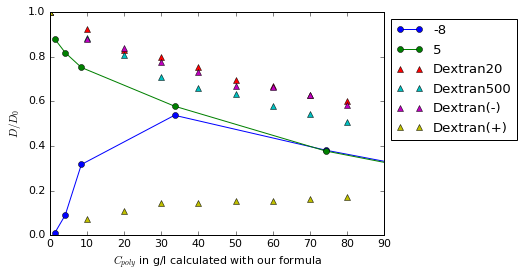

In [96]:
uArr = [-8,5]
kArr = ['0.670','0.750'] # kdir must correspond to U_0 values. They are different, due to different buffer used by Jason
data = getCpolyData(uArr,kArr)
plotCpolyData(data)

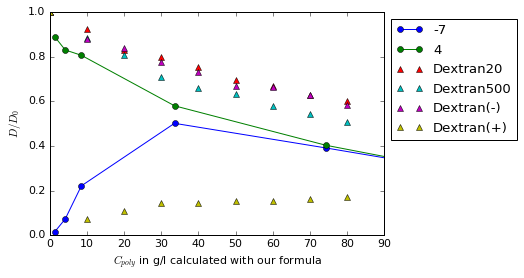

In [99]:
uArr = [-7,4]
kArr = ['0.840','0.940'] # kdir must correspond to U_0 values. They are different, due to different buffer used by Jason
data = getCpolyData(uArr,kArr)
plotCpolyData(data)

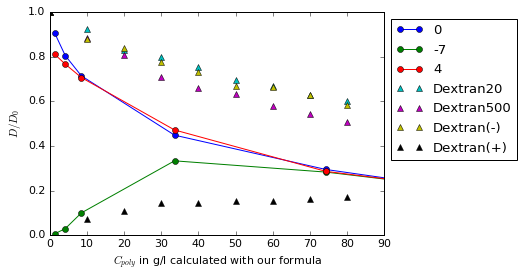

In [100]:
uArr = [0,-7,4]
kArr = 3*['1.000']
data = getCpolyData(uArr,kArr,dt='0.0005')
plotCpolyData(data)

### Correction to the result of eq. 22 in relation to the experimental value
In the experiment in fig. 13 in our EPJE paper, Jason used an polymer concentration of 1(w/v)\%.
With our formula in eq. 22, we obtain 0.39(w/v)\%.
So, to correct the polymer concentrations calculated with eq. 22, we weight the calculated polymer concentration with the ratio of the experimental value, to the calculated value.
The resulting data fits Jasons data much better (compare it to bpj fig. 4)

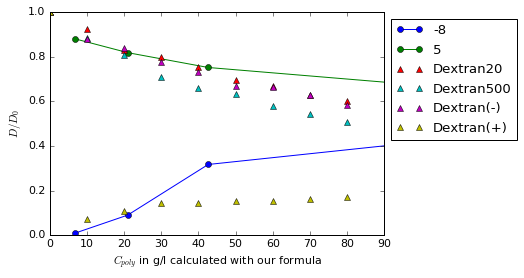

In [101]:
uArr = [-8,5]
kArr = ['0.670','0.750'] # kdir must correspond to U_0 values. They are different, due to different buffer used by Jason
data = getCpolyData(uArr,kArr)
plotCpolyData(data,32,True)

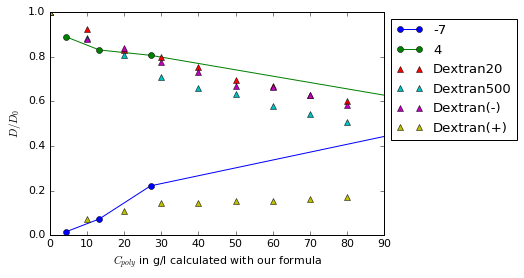

In [103]:
uArr = [-7,4]
kArr = ['0.840','0.940'] # kdir must correspond to U_0 values. They are different, due to different buffer used by Jason
data = getCpolyData(uArr,kArr)
plotCpolyData(data,25.5,True)

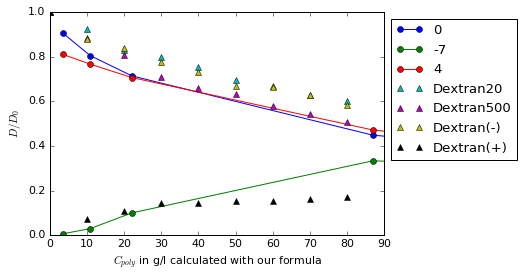

In [106]:
uArr = [0,-7,4]
kArr = 3*['1.000']
data = getCpolyData(uArr,kArr,dt='0.0005')
plotCpolyData(data,23,True)

# TODO find more suitable parameters a/b and p/b
# EVALUATE DATA FROM SHELDON
/Users/jh/Documents/Remote_PC/sheldon_scratch/HI/sim/Release/sim_data/noreset/fitRPinv/test/CG/ntry1/nrods1/steric

I need to run simulations for this as soon as I found a good mesh size for the HI simulations in comparison to Jasons data.
With the new data: I need to re-run the simulations with:
- correct $U_0$ values, that lead to good agreement Cion data
- correct $k$ values, calculated with krelFromCion(Cion,b_ex). Here, I need to use the
- correct $b_ex$ value, that leads to good agreement in the Cion plot for the HI simulations
Finally, using the new simulation data, I have to plot the data WITH and WITHOUT the appropriate Correction term cpolyCorrection


_______
______
_____

# Compare fig 2 to simulations
According to Jason, PEG has a monomer diameter of about 0.4 to 0.5. *This already includes hydration* since it is the hydrodynamic radius of a PEG monomer.

The problem is: I do not really know, whether our calculation in eq. (22) in the epje paper applies here. Since a) I do not know if the hydrodynamic radius a_ex is the same as the width of a PEG monomer along the polymer chain, and b) I do not know whether PEG form polymer bundles or something like that. In other words, I don't know if our assumptions about the tetrafunctional crosslinks for eq. (22) fits.

In [200]:
a_ex = 0.45

# ALEXA: --> aop=0.3
p_ex = 1.5

# phycoerythrin
# p_ex = 5.6 --> aop = 0.08

